# Convert .msh grid to .gr3

In [6]:
#to use the full width of the browser window uncomment the code below and execute the cell
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import pandas as pd
import numpy as np
from mayavi import mlab
from mayavi.sources.builtin_surface import BuiltinSurface

In [2]:
import pyresample

In [3]:
from shutil import copyfile

In [4]:
import shapely

In [5]:
mlab.init_notebook()

Notebook initialized with x3d backend.


## read .msh

In [6]:
msh='/Users/brey/GitHub/jigsaw-geo-matlab/jigsaw/out/EARTH-CONST-MESH.msh'

In [ ]:
msh='/Users/brey/GitHub/jigsaw-geo-matlab/jigsaw/out/EARTH-REGIONAL-MESH.msh'

In [6]:
msh='/Users/brey/Downloads/JIGSAW/out/Global.msh'

In [7]:
#extract number of elements, number of nodes
p,nn=pd.read_csv(msh,header=2,skiprows=1,nrows=0,delimiter='=')

In [8]:
nn=int(nn)

In [9]:
nn

188494

In [10]:
#read lon,lat,depth for all nodes
xy=pd.read_csv(msh,skiprows=4,header=None,delimiter=';',engine='python',nrows=nn,names=['x','y','z','q'])

In [11]:
xy.shape

(188494, 4)

In [12]:
xy.index=xy.index+1

In [13]:
xy.head()

,x,y,z,q
1,-3.749826,-0.507305,6370.998876,0
2,30.748207,55.378945,-6370.685106,0
3,6370.978370,2.890478,16.348038,0
4,-1.680920,6370.994689,8.052714,0
5,-6370.985760,-13.067623,3.268658,0


In [14]:
xy.tail()

,x,y,z,q
188490,-3184.906967,4221.028931,3553.719654,0
188491,4436.058366,3681.725969,-2712.180131,0
188492,3963.060647,373.878801,4974.334725,0
188493,349.909896,4062.737666,4895.034905,0
188494,-2115.882283,5966.050926,-720.360684,0


In [15]:
#power,pn=pd.read_csv(msh,header=4,skiprows=nn,nrows=0,delimiter='=')
#power, pn

In [16]:
#pn,s = pn.split(';')

In [17]:
#pn = int(pn)
#pn

In [18]:
#pr=pd.read_csv(msh,skiprows=nn+5,header=None,delimiter=';',engine='python',nrows=pn,names=['a'])
#pr.head()

In [19]:
#typ,ne=pd.read_csv(msh,header=4,skiprows=nn+pn+1,nrows=0,delimiter='=')
#typ, ne

In [20]:
typ,ne=pd.read_csv(msh,header=4,skiprows=nn,nrows=0,delimiter='=')
typ, ne

('TRIA3', '376984')

In [21]:
ne = int(ne)

In [22]:
tr=pd.read_csv(msh,skiprows=nn+5,header=None,delimiter=';',engine='python',nrows=ne,names=['a','b','c','q'])

In [23]:
tr.index=tr.index+1

In [24]:
tr['q']=3

In [25]:
tr.head()

,a,b,c,q
1,65934,65935,65936,3
2,34672,34671,72131,3
3,172054,150772,172405,3
4,25935,72557,128305,3
5,56475,149360,156062,3


In [26]:
tr.tail()

,a,b,c,q
376980,38524,173205,188493,3
376981,173205,116544,188493,3
376982,116544,165317,188493,3
376983,188493,99951,186307,3
376984,38524,188493,186307,3


In [27]:
tri3 = tr.loc[:,['a','b','c']].values

In [28]:
# read back files
grid = pd.read_csv('grid', index_col=0)

## Mask Land

In [36]:
land = np.load('land_index.npz')['arr_0']

In [37]:
bns = np.load('bns.npz')['arr_0'] 

In [103]:
gcrop = pd.read_csv('gcrop',index_col=0)
ecrop = pd.read_csv('ecrop',index_col=0)

In [104]:
gcrop.head()

,x,y,z,q,lon,lat
1,-3.749826,-0.507305,6370.998876,0.0,-172.295365,89.965970
2,6370.978370,2.890478,16.348038,0.0,0.025995,0.147022
3,-1.680920,6370.994689,8.052714,0.0,90.015117,0.072420
4,-6370.985760,-13.067623,3.268658,0.0,-179.882480,0.029396
5,-1.905772,-6370.993890,8.615335,0.0,-90.017139,0.077480


In [105]:
ecrop.head()

,a,b,c,q,x1,y1,x2,y2,x3,y3,val,s1,s2,s3
1,57565,57567,57566,3,-152.049709,-30.508845,-152.548847,-30.393800,-152.416943,-30.828068,-0.201585,-1.0,-1.0,-1.0
2,30277,62909,30276,3,6.179056,-17.011670,5.822087,-17.302412,6.265693,-17.453018,-0.182737,1.0,1.0,1.0
3,152565,152895,131736,3,110.771125,-47.894409,111.178923,-47.541181,110.515668,-47.484343,-0.257458,1.0,1.0,1.0
4,22773,109352,63330,3,83.127768,0.581281,83.453917,0.890252,83.024470,1.017339,-0.174136,1.0,1.0,1.0
5,49246,137011,130328,3,-167.237513,-19.483809,-166.917362,-19.815202,-166.769652,-19.388138,-0.185675,-1.0,-1.0,-1.0


In [121]:
def renum(elems):
    ptr3 = ecrop.loc[elems,['a','b','c']]
    pxy = gcrop.loc[np.unique(ptr3.values)]
    pxy.reset_index(inplace=True)
    ptr3.reset_index(inplace=True, drop=True)

    #re-index for plotting
    for i in range(ptr3.a.size):
        ptr3.loc[i,'na'] = pxy[pxy.loc[:,'index'] == ptr3.loc[i,'a']].index
        ptr3.loc[i,'nb'] = pxy[pxy.loc[:,'index'] == ptr3.loc[i,'b']].index
        ptr3.loc[i,'nc'] = pxy[pxy.loc[:,'index'] == ptr3.loc[i,'c']].index

    ptr3 = ptr3.loc[:,['na','nb','nc']].astype(int) #keep only the new index
    return pxy,ptr3

In [122]:
pxy, ptr3 = renum([3,4])

In [97]:
celem = ecrop.loc[:,['a','b','c']].values - 1 # to make index.min == 0 for the plot below

In [ ]:
mlab.clf()
# 3D triangular mesh surface (like trisurf)
mlab.triangular_mesh(gcrop['x'].values,gcrop['y'].values,gcrop['z'].values,celem , representation='wireframe', color=(0, 0, 0))#, opacity=0.5)#, scalars=xy['dep'].values)
mlab.triangular_mesh(pxy['x'].values,pxy['y'].values,pxy['z'].values,ptr3 , representation='surface', color=(1, 1, 0))#, opacity=0.1)#, scalars=xy['dep'].values)

## Read Bathymetry

In [162]:
fbath = '/Users/brey/GitHub/jigsaw-geo-matlab/jigsaw/geo/topo.msh'
coord, nc = pd.read_csv(fbath,header=2,skiprows=1,nrows=0,delimiter='=')
coord, nc
nc0, nc1 = nc.split(';')
nlon = int(nc1)
#read lon for all boundary nodes
xb = pd.read_csv(fbath,skiprows=4,header=None,nrows=nlon,names=['lon'])
coord, nc = pd.read_csv(fbath,header=4,skiprows=nlon,nrows=0,delimiter='=')
coord, nc
nc0, nc2 = nc.split(';')
nlat = int(nc2)
#read lat,depth for boundary nodes
yb = pd.read_csv(fbath,skiprows=5 + nlon,header=None,nrows=nlat,names=['lat'])
value, nc = pd.read_csv(fbath,header=4,skiprows=nlon+nlat+1,nrows=0,delimiter='=')
value, nc
val, val0 = nc.split(';')
val = int(val)
#read 
bath = pd.read_csv(fbath,skiprows=6 + nlon + nlat,header=None,nrows=val,names=['value'])
vb = bath.values.reshape(nlon,nlat)
zlev = vb.T

## resample on grid points

In [163]:
X, Y = np.meshgrid(xb.lon.values, yb.lat.values)

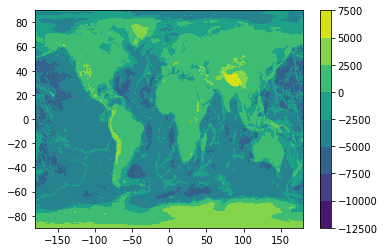

In [164]:
### plot
plt.figure()
plt.contourf(X,Y,zlev)
plt.colorbar()

In [165]:
#mask the positive values
wet = np.ma.masked_array(zlev,zlev>0)
# wet.fill_value = 0.
mx = np.ma.masked_array(X,wet.mask) 
my = np.ma.masked_array(Y,wet.mask)

In [166]:
wet

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [-3647, -3735, -3724, ..., -3786, -3766, -3649],
        [-4140, -4134, -4133, ..., -4159, -4147, -4139],
        [-4120, -4120, -4120, ..., -4120, -4120, -4120]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=999999)

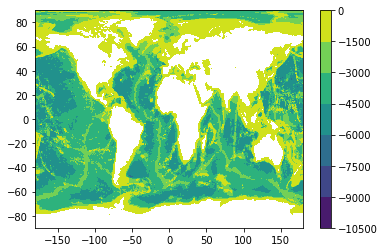

In [167]:
### plot
plt.figure()
plt.contourf(mx,my,wet)
plt.colorbar()

In [168]:
orig = pyresample.geometry.SwathDefinition(lons=mx,lats=my) # original points
targ = pyresample.geometry.SwathDefinition(lons=gcrop.lon.values,lats=gcrop.lat.values) # target grid
       
ibath = pyresample.kd_tree.resample_nearest(orig,wet,targ,radius_of_influence=50000,fill_value=0)


In [169]:
ibath.min(), ibath.max()

(-10141, 0)

### visualize

In [160]:
ptr3 = ecrop.loc[17:17,['a','b','c']]

pxy = gcrop.loc[np.unique(ptr3.values)]

pxy.reset_index(inplace=True)

ptr3.reset_index(inplace=True)

pxy.head()

ptr3.head()

#re-index for plotting
for i in range(ptr3.a.size):
    ptr3.loc[i,'na'] = pxy[pxy.loc[:,'index'] == ptr3.loc[i,'a']].index
    ptr3.loc[i,'nb'] = pxy[pxy.loc[:,'index'] == ptr3.loc[i,'b']].index
    ptr3.loc[i,'nc'] = pxy[pxy.loc[:,'index'] == ptr3.loc[i,'c']].index

ptr3 = ptr3.loc[:,['na','nb','nc']].astype(int) #keep only the new index

In [161]:
pxy

,index,x,y,z,q,lon,lat
0,14357,-4851.576232,-668.225019,4074.963115,0.0,-172.157788,39.762836
1,14358,-4866.981242,-810.478699,4030.540766,0.0,-170.545522,39.245066
2,14742,-4941.042820,-703.148768,3959.964477,0.0,-171.900747,38.430209


In [162]:
ptr3 

,na,nb,nc
0,1,0,2


In [ ]:
mlab.clf()
# 3D triangular mesh surface (like trisurf)
mlab.triangular_mesh(gcrop['x'].values,gcrop['y'].values,gcrop['z'].values,tri, representation='wireframe', opacity=0.8)

surf = mlab.triangular_mesh(gcrop['x'].values,gcrop['y'].values,gcrop['z'].values,tri, representation='surface', opacity=0.8 , scalars=ibath, colormap='gist_earth')
mlab.triangular_mesh(pxy['x'].values,pxy['y'].values,pxy['z'].values,ptr3 , representation='surface', color=(0, 0, 1))


#mlab.colorbar(title='Bathymetry', orientation='vertical')
mlab.points3d(pxy.x[0],pxy.y[0],pxy.z[0], colormap='copper', scale_factor=100 )
mlab.points3d(pxy.x[1],pxy.y[1],pxy.z[1], colormap='copper', scale_factor=100 )
mlab.points3d(pxy.x[2],pxy.y[2],pxy.z[2], colormap='copper', scale_factor=100 )


In [472]:
gcrop['dep'] = -ibath # make bathymetry positive 

In [171]:
nn = gcrop.shape[0]
ne = ecrop.shape[0]

## save to file

### Compute internal land boundaries

In [479]:
gcrop.head()

,index,x,y,z,q,lon,lat,dep
1,1,-3.749826,-0.507305,6370.998876,0.0,-172.295365,89.965970,4121
2,3,6370.978370,2.890478,16.348038,0.0,0.025995,0.147022,4933
3,4,-1.680920,6370.994689,8.052714,0.0,90.015117,0.072420,4197
4,5,-6370.985760,-13.067623,3.268658,0.0,-179.882480,0.029396,5262
5,6,-1.905772,-6370.993890,8.615335,0.0,-90.017139,0.077480,940


#### All ...

In [211]:
len(bns), len(xi)

(1422, 1422)

In [208]:
lbound = [x for x in bns if len(x) > 0]

In [333]:
len(lbound)

373

In [336]:
bound=pd.DataFrame({})
for i in range(len(lbound)):
        bound = pd.concat([bound , gcrop.loc[gcrop['index'].isin(lbound[i])]])
     

In [337]:
bound.shape

(7966, 10)

In [338]:
bound.head()

,level_0,index,x,y,z,q,lon,lat,dep,man
5335,5348,5705,-1237.176135,-1155.612652,-6141.953729,0.0,-136.952297,-74.589908,297,0.12
5336,5349,5706,-1227.801796,-1206.852467,-6133.975128,0.0,-135.492998,-74.322150,193,0.12
5337,5350,5708,-1178.756692,-1228.627204,-6139.271036,0.0,-133.813251,-74.499375,868,0.12
5338,5351,5710,-1127.706166,-1250.875887,-6144.365656,0.0,-132.035710,-74.671749,185,0.12
5340,5353,5713,-1073.321802,-1276.137532,-6148.910010,0.0,-130.066206,-74.827118,0,0.12


In [ ]:
#check

In [ ]:
mlab.clf()
# 3D triangular mesh surface (like trisurf)
mlab.triangular_mesh(gcrop['x'].values,gcrop['y'].values,gcrop['z'].values,tri, representation='wireframe', opacity=0.8)
mlab.points3d(bound['x'].values,bound['y'].values,bound['z'].values, colormap="copper", scale_factor=10)




In [340]:
bound.to_csv('bound')

### Combine points

In [480]:
ecrop.head()

,a,b,c,q,x1,y1,x2,y2,x3,y3,val,s1,s2,s3
1,57565,57567,57566,3,-152.049709,-30.508845,-152.548847,-30.393800,-152.416943,-30.828068,-0.201585,-1.0,-1.0,-1.0
2,30277,62909,30276,3,6.179056,-17.011670,5.822087,-17.302412,6.265693,-17.453018,-0.182737,1.0,1.0,1.0
3,152565,152895,131736,3,110.771125,-47.894409,111.178923,-47.541181,110.515668,-47.484343,-0.257458,1.0,1.0,1.0
4,22773,109352,63330,3,83.127768,0.581281,83.453917,0.890252,83.024470,1.017339,-0.174136,1.0,1.0,1.0
5,49246,137011,130328,3,-167.237513,-19.483809,-166.917362,-19.815202,-166.769652,-19.388138,-0.185675,-1.0,-1.0,-1.0


In [483]:
bels = ecrop.loc[(ecrop.a.isin(lbound[0])) | (ecrop.b.isin(lbound[0])) | (ecrop.c.isin(lbound[0]))]

In [484]:
bels.head()

,a,b,c,q,x1,y1,x2,y2,x3,y3,val,s1,s2,s3
225,14538,14539,14387,3,-35.453771,6.226889,-35.475780,6.675130,-35.854580,6.429599,-0.175198,-1.0,-1.0,-1.0
340,127760,164448,720,3,5.334106,-22.386938,5.712184,-22.471913,5.717620,-22.024765,-0.169519,1.0,1.0,1.0
495,42135,151517,42134,3,147.241650,0.099254,147.058251,-0.312891,147.505597,-0.269254,-0.176368,1.0,1.0,1.0
510,136252,160937,97357,3,-112.615965,19.393252,-112.709461,19.828759,-113.061846,19.544316,-0.180061,-1.0,-1.0,-1.0
545,46141,49194,49193,3,-67.002355,-59.044297,-67.640136,-58.722330,-67.856958,-59.146235,-0.340168,-1.0,-1.0,-1.0


In [486]:
ies = bels.loc[:,['a','b','c']].values.flatten()

In [361]:
idb=lbound[0]
for i in range(1,len(lbound)):
    ibels = bels.loc[(ecrop.a.isin(lbound[i])) | (bels.b.isin(lbound[i])) | (bels.c.isin(lbound[i]))]
    if ibels.shape[0] > 0 :
        idb = idb + lbound[i]

In [362]:
len(idb)

5708

In [363]:
df =gcrop.loc[gcrop.index.isin(idb)]

In [494]:
df0 =gcrop.loc[gcrop['index'].isin(lbound[0])]

In [495]:
df1 =gcrop.loc[gcrop['index'].isin(ies)]

In [ ]:
#check
mlab.clf()
# 3D triangular mesh surface (like trisurf)
mlab.triangular_mesh(gcrop['x'].values,gcrop['y'].values,gcrop['z'].values,tri, representation='wireframe', opacity=0.8)
mlab.points3d(df0['x'].values,df0['y'].values,df0['z'].values, colormap="copper", scale_factor=10)
mlab.points3d(df1['x'].values,df1['y'].values,df1['z'].values, colormap="Blues", scale_factor=20)

### output

In [307]:
folder = '/Users/brey/GLOBAL/SCHISM_GLOBAL_2/'

In [308]:
g3file = folder + 'hgrid.gr3'

In [309]:
with open(g3file,'w') as f:
    f.write('\t uniform.gr3\n')
    f.write('\t {} {}\n'.format(ne,nn))
    

In [310]:
gcrop.to_csv(g3file,index=True, sep='\t', header=None,mode='a', float_format='%.10f', columns=['lon','lat','dep'])

In [311]:
ecrop.to_csv(g3file,index=True, sep='\t', header=None, mode='a', columns=['q','a','b','c'])

In [312]:
with open(g3file, 'a') as f:
    f.write('{} = Number of open boundaries\n'.format(0))
    f.write('{} = Total number of open boundary nodes\n'.format(0))

In [313]:
with open(g3file, 'a') as f:
    f.write('{} = Number of land boundaries\n'.format(len(lbound)))
    f.write('{} = Total number of land boundary nodes\n'.format(bound.shape[0]))

    total = 0 
    for i in range(len(lbound)):
        ibound=gcrop.loc[gcrop['index'].isin(lbound[i])]
        f.write('{} 1 = Number of nodes for land boundary {}\n'.format(ibound.shape[0], i+1))
        total += ibound.shape[0]
        for item in ibound['index'].values:
            f.write("%s\n" % item)

In [317]:
bound.shape[0], total

(7966, 7966)

### hgrid.ll

In [318]:
llfile=folder+'hgrid.ll'

In [319]:
copyfile(g3file, llfile)

'/Users/brey/GLOBAL/SCHISM_GLOBAL_2/hgrid.ll'

### Save manning.gr3

In [320]:
manfile=folder+'manning.gr3'

In [321]:
with open(manfile,'w') as f:
    f.write('\t 0 \n')
    f.write('\t {} {}\n'.format(ne,nn))

In [322]:
gcrop['man']=.12
gcrop.head()

,level_0,index,x,y,z,q,lon,lat,dep,man
1,1,1,-3.749826,-0.507305,6370.998876,0.0,-172.295365,89.965970,4121,0.12
2,2,3,6370.978370,2.890478,16.348038,0.0,0.025995,0.147022,4933,0.12
3,3,4,-1.680920,6370.994689,8.052714,0.0,90.015117,0.072420,4197,0.12
4,4,5,-6370.985760,-13.067623,3.268658,0.0,-179.882480,0.029396,5262,0.12
5,5,6,-1.905772,-6370.993890,8.615335,0.0,-90.017139,0.077480,940,0.12


In [323]:
gcrop.to_csv(manfile,index=True, sep='\t', header=None,mode='a', float_format='%.10f',columns=['lon','lat','man'] )

In [324]:
ecrop.to_csv(manfile,index=True, sep='\t', header=None, mode='a', columns=['q','a','b','c'])